In [ ]:
% First, make sure that the ESC toolbox functions are in the path
addpath readonly

In [7]:
% If you wish to create an Rint model, simply set rcValues equal
% to the value of R0 (in milliohms).
% If you wish to create a Thévenin model, define rcValues to be 
% a vector having three elements. The first element is R0 (in
% milliohms), the second element is R1 (in milliohms), and the 
% third element is C1 (in kilofarads).
% If you wish to create an extended Thévenin model having 
% additional resistor-capacitor branches, then define rcValues to
% be a vector where the first element is R0 in milliohms, the 
% even-index elements (rcValues(2:2:end)) are resistor values for
% the resistor-capacitor branches, in milliohms, and the remaining
% odd-index elements (rcValues(3:2:end)) are capacitor values for
% the resistor-capacitor branches, in kilofarads.

function rcValues = tuneModel

  % BEGIN MODIFYING CODE AFTER THIS
  rcValues = [10] % This is a sample value. You will need to change it.
end  

rcValues =  10
Your tuning values produced an RMS voltage-prediction error of 27.3621 mV


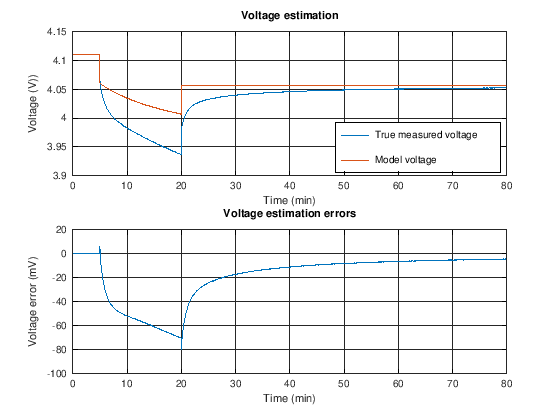

In [8]:
% Load data file to use for this capstone project
% - these data have the fields: time, current, voltage
% Also load a skeleton ESC model structure
% - has total capacity and OCV relationship
load readonly/pulseData.mat; % load data to use for this project
load readonly/pulseModel.mat; % load SOC/OCV relationships, capacity
T = 25;                            % Test temperature
deltaT = 1;                        % sampling period for data
Q = getParamESC('QParam',T,model); % total capacity of cell

tk = pulseData.time;    % testing time
ik = pulseData.current; % testing current
vk = pulseData.voltage; % testing voltage

% Get tuning values from user-modified function
rcValues = tuneModel;

% Simulate cell model using user-modified rcValues
R0 = rcValues(1)/1000; % convert milliohms to ohms
R = rcValues(2:2:end)/1000; % convert these also
C = rcValues(3:2:end)*1000; % convert kF to F
RCfact = exp(-deltaT./(R.*C));
    
% Simulate the dynamic states of the model
iRk = zeros(length(RCfact),1); % initial resistor currents
vCk = 0*pulseData.voltage; % initialize capacitor voltages
if ~isempty(RCfact)
  for k = 2:length(vCk)
    iRk = diag(RCfact)*iRk + (1-RCfact)*ik(k-1); % update resistor current
    vCk(k) = R'*iRk; % compute capacitor voltage
  end
end

% Simulate SOC state
z0 = SOCfromOCVtemp(pulseData.voltage(1),25,model); 
zk = z0-cumsum([0;ik(1:end-1)])*deltaT/(Q*3600); 

% Compute voltage estimate
vest = OCVfromSOCtemp(zk,25,model) - vCk - ik.*R0;

% Compare against measured voltage, compute RMSE in mV
rmse = 1000*sqrt(mean((vk - vest).^2));

% Plot some results 
subplot(2,1,1); plot(tk/60,vk,tk/60,vest); 
title('Voltage estimation'); grid on
xlabel('Time (min)'); ylabel('Voltage (V))'); 
legend('True measured voltage','Model voltage','location','southeast');

subplot(2,1,2); plot(tk/60,1000*(vk-vest)); 
title('Voltage estimation errors');
xlabel('Time (min)'); ylabel('Voltage error (mV)');
grid on
fprintf('Your tuning values produced an RMS voltage-prediction error of %g mV\n',rmse);